# Data Analytics for MOOC Providers

#### Created by [Miguel Ballesteros](mailto:mabm1e15@soton.ac.uk)

### *Notebook list*
1. [Introduction](index.ipynb)
2. [The Downloaded CSV Files](downloaded_data.ipynb)
3. [Data Processing Pipeline](data_pipeline.ipynb)
4. **[Clean Data Exploration](clean_data_exploration.ipynb)**
5. [Understanding MOOC behaviors](understanding_mooc.ipynb)
6. [Predicting Dropouts](predicting_dropouts)
7. [Conclusions](conclusions.ipynb)
8. [Future Work](future_work.ipynb)

### *In this notebook...*
1. [Exploration Goal](#Exploration-Goal)
2. [Data Load](#Data-Load)
3. [Course Data Frames](#Course-Data-Frames)
4. [Enrolments Data Frame](#Enrolments-Data-Frame)
5. [Step Activity Data Frame](#Step-Activity-Data-Frame)

## Exploration Goal

Within this notebook the cleaned data is explored with the aim to determine the possible transformations to use in later models. The cleaned data is basically the raw data after removing invalid entries and converting all columns to the right data types.

The task starts by loading the cleaned data from the RData file saved in the folder Data_Clean using the same methods defined for the pipeline processing. Then the data frames are listed. When using the default values, those are identified with the prefix "df_".

## Data Load

In [25]:
source("00_config.r")              # R file with global configuration values
source("02_clean.r")               # R file with clean-related functions
load_clean_data_file(DATA_CLEAN)   # Function defined in the clean functions. Loads the preprocessed clean data.
summary_clean_data()               # Table summarizing the number of records per data frame, grouped by the short course name

[1] "INFO - START - load_clean_data_file"
[1] "INFO - END - load_clean_data_file - Elapsed: 3.45999999999913 s"


short_code,df_course_list,df_course_details,df_enrolments,df_step_activity,df_comments,df_pr_assignments,df_pr_reviews,df_question_response
research-project-1,1,80,8642,127967,14454,1105,1808,17222
research-project-2,1,80,9844,119787,12661,1063,1573,12807
research-project-3,1,80,13232,144700,14581,1235,1752,20692
research-project-4,1,80,10361,156399,13074,1467,1839,26014
research-project-5,1,80,6569,69393,8111,554,824,9214
understanding-language-1,1,64,58788,468309,145425,0,0,0
understanding-language-2,1,66,41916,318232,86139,0,0,0
understanding-language-3,1,66,44287,229217,58285,0,0,0
understanding-language-4,1,66,25596,197929,50332,0,0,0
web-science-1,1,124,13674,231958,18414,0,0,104588


In the previous table a list of all loaded courses and number of records for each data source is displayed. Please keep in mind the notation of the short_code field, since it is the unique name used to link all data sources, and the main parameter for many operations.

* **df_course_XXXX:** These data frames were custom built and those are not expected to contain issues. However, basic verifications are done to ensure the data is consistent and ready for transformation.
* **df_enrolments:** This is the most important source of participant's data. It has just a little of demographic details, so it's important to verify exactly how reliable or relevant is such data. The role field is important to remove those participants performing only administrative actions. The enrolled_at field may be helpful as a predictor factor for the dropout analysis, transformed as X hours or days before/after the course start date.
* **df_step_activity:** This data frame contains the most important participant-course interaction information. However, it is given only as a set of two dates: *first_visited_at* and *last_completed_at*. All other fields are used for classification within the course-week-step and link to the enrolment data. For this reason, at this point during the data cleaning the duration (difference between the two dates) was calculated with the aim to find patterns and understand navigation behaviors in the course.
* **df_pr_XXX:** These data frames are relevant only for some courses, and with just few entries compared to the total number of participants. However due to the high amount of text  it may be useful to apply NLP analytics and calculate some indices that later may be helpful for the dropout prediction (as performed in a previous study). Apparently just the participation in the assessment seem to suggest something about the level of engagement.
* **df_question_response:** contains all question-response attempts either those are correct or incorrect. This data may be useful to calculate an index for the number of retries, that at the same time may help measuring the level of engagement and therefore, useful for the dropout prediction.


## Course Data Frames
Even if this data is expected to be OK, the number of weeks are calculated for the total course range as well as each week-step from the course details. This basic calculation was performed during the clean step mainly for verification proposes.

* Please check that the total_weeks value in the course_list table is the expected one. Otherwise, verify that the times are correct and also verify if there's a summer time change that may affect the calculation. This is a known issue which requires to add 1 hour to the end_date of the week the change takes place.

- TODO: Show the calculated number of days for course_details records, or show exceptions not matching 7.


In [26]:
df_course_list[,c("short_code", "start_date", "end_date", "total_weeks")]

short_code,start_date,end_date,total_weeks
research-project-1,2014-07-07,2014-09-01 00:00:00,8
research-project-2,2014-09-15,2014-11-10 00:00:00,8
research-project-3,2015-06-22,2015-08-17 00:00:00,8
research-project-4,2015-09-14,2015-11-09 00:00:00,8
research-project-5,2016-03-07,2016-05-02 01:00:00,8
web-science-1,2013-11-11,2013-12-23 00:00:00,6
web-science-2,2014-02-10,2014-03-24 00:00:00,6
web-science-3,2014-10-06,2014-11-17 00:00:00,6
web-science-4,2015-11-30,2015-12-14 00:00:00,2
web-science-5,2016-06-27,2016-07-11 00:00:00,2


## Enrolments Data Frame

- Calculate the number of participants enroled in more than 1 course <- This has to be done in a transformed participant only data frame
- Separate or identify the participant role to avoid some noise for admin activities
- Calculate the percentage of exising data for all demographic fields



In [27]:
nrow(df_enrolments)
table(df_enrolments$role)

[1] 259828


             admin            learner           marketer          moderator 
               179             259212                  2                  1 
organisation_admin 
               434 

## Step Activity Data Frame

- Filtered by short_code, plot the LOG histogram of the duration field for all week-step combinations. Add a reference line with the median, mean and expected time.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


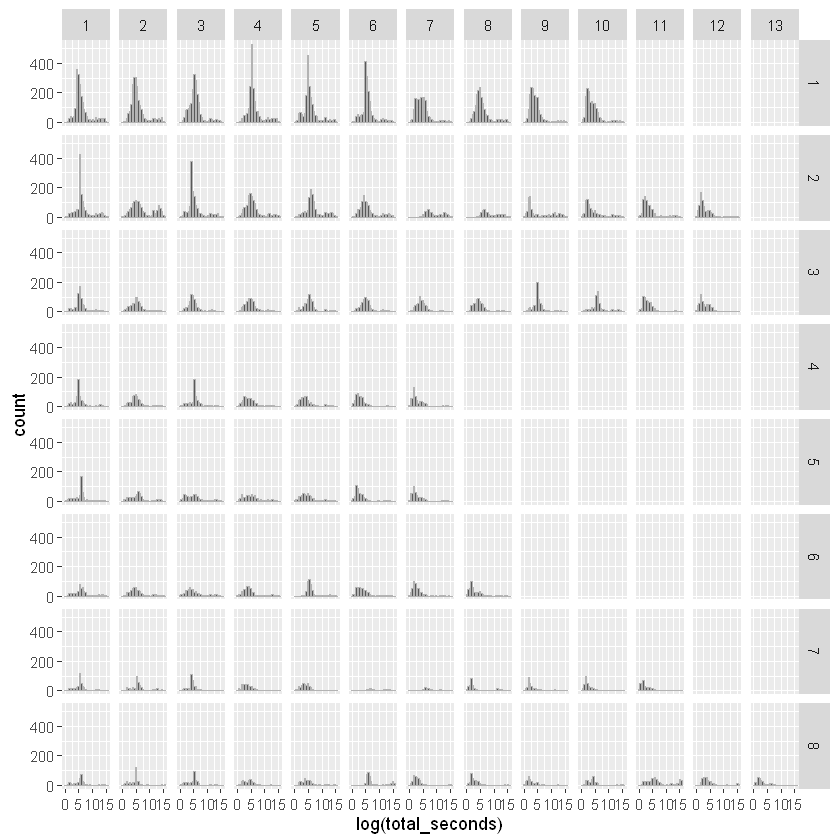

In [22]:
# library(ggplot2)
df_plot <- df_step_activity[df_step_activity$short_code == "research-project-5" & !is.na(df_step_activity$total_seconds), c("short_code", "week_number", "step_number", "total_seconds")]
ggplot(df_plot) +
  geom_histogram(aes(x = log(total_seconds)), color = "grey70") + 
  facet_grid(week_number~step_number)